# Support Vector Machines

### Linearly Separable Data
In a nutshell, SVMs work by searching for the hyperplane that provides optimal separation between two classes in feature space. In the multiclass problem this is done using a one-vs-all approach.

A linear classifier has a decision function that is linear in the input examples and is expressed as

$$f(\vec{x})=\vec{w}^T\vec{x}+b$$

where the vector $\vec{w}$ is known as the weight vector, $b$ is the bias, and $\vec{w}^T\vec{x}$ is the matrix way of writing the dot product: $\vec{w} \cdot \vec{x}$. The decision boundary of the classifier is where $f(\vec{x})=0$.

The hyperplane defined by the decision function divides the feature space into two according to the sign of the function, and by convention the positive examples are characterized by positive values and negative examples by negative values.

Any hyperplane splitting the feature space carries with it two additional hyperplanes (known as *margins*) which pass through no less than two examples in the feature space, known as *support vectors*. The width of the margins of the split can be expressed in the terms of the weight vectors as

$$f(\vec{x}_+)=\vec{w}^T\vec{x}_++b=a>0 \\
f(\vec{x}_-)=\vec{w}^T\vec{x}_-+b=-a<0$$

By yet another convention the "coordinates" $(\vec{w},b)$ are rescaled by a factor of $1/a$ to obtain the *equations of the hyperplanes defining the margins*:

$$f(\vec{x}_+)=\vec{w}^T\vec{x}_++1 \\
f(\vec{x}_-)=\vec{w}^T\vec{x}_-+b=-1$$

and now examples outside of the margin will return values greater than $1$ or less than $-1$.

The total width of the margin is then $d=2/||w||$.

The goal of the SVM algorithm is to maximize the width of the margin, or in other words to minimize the L2 norm (heh... flashbacks to Advanced Calculus) $\frac{1}{2}||w||^{2}$, subject to the boundary condition $y^i(\vec{w}^T\vec{x}+b)\ge1$ where $y^i$ is $-1$ for negative examples and $+1$ for positive examples.

Another useful tool in the SVM formalism is that the weight vector is a superposition of the training examples:

$$\vec{w}=\sum^n_{i=1}y_i\alpha_i\vec{x}_i$$

where $\alpha_i$ is nonzero only for the training examples that serve as support vectors. Often these examples are sparse and the number of support vectors in general serves as an upper boound on the error rate of the classifier.

### Nonseparable Data Sets and Slack Variables

The hyperplane split described above works well for data sets that are linearly separable. If they cannot be separated linearly, then we have to accept that (1) there will be examples that lie within the margin and (2) there will be examples that are mis-classified. A penalty to each of these cases are known as *slack variables* $\xi_i\in (0, 1)$. Slack variables describe the distance between the margin and the examples. The further the example from the margin, the worse the performance. Thus, the goal is to maximize the size of the margin while at the same time minimizing the sum of the penalty terms associated with examples within the margin. Mathematically:
$$
\mathrm{minimize} \ \frac{1}{2}||w||^2+C\sum_i\xi_i \\
\mathrm{subject \ to} \ y^i(\vec{w}^T\vec{x}+b)\ge 1
$$
where $C$ is a regularization parameter that regulates the trade-off between having a wide margin and having few misclassifications.

### Kernel Functions

Sometimes it is possible to project the data into a higher dimension where they *can* be separated, given an appropriate transformation matrix, such that $\vec{x}'=\phi(\vec{x})$. The decision function for such a transformation becomes a function of the dot product between the transformed data and the transformed support vectors $\phi(\vec{z})$.

Thankfully, it can be shown that for some special functions $K(\vec{x}, \vec{z})$ (*Mercer kernels*) any possible feature mapping involving the dot product $\phi(\vec{x})\cdot\phi(\vec{z})$ can be replaced by $K(\vec{x}, \vec{z})$. Equivalently, any valid Mercer kernel corresponds to a specific feature mapping. A further perk of this result is that the complexity of computing $K(\vec{x}, \vec{z})$ is only ever $\mathcal{O}(N)$, regardless of the dimensionality of the transformed feature space.

### Hyperparameters

#### Type of Kernel
The three most common kernel functions are the (1) linear kernel, (2) the polynomial kernel, and (3) the Gaussian kernel (sometimes called the "radial basis function", as in $\texttt{sklearn}$)

The linear case is the simplest, in which the possible separating surfaces are hyperplanes in the original feature space. The kernel is essentially the identity matrix.

$$K(\vec{x}, \vec{x}')=\hat{I}$$

In the case of the polynomial kernel we have

$$K(\vec{x}, \vec{x}')=(\vec{x}^T\vec{x}+1)^d,$$

and the SVM works in a new space whose features are all the possible combinations of monomials of degree up to $d$.

Lastly, the Gaussian kernel takes form

$$K(\vec{x}, \vec{x}')=\exp\{-\gamma||\vec{x}-\vec{x}'||^2\}.$$

#### Regularization parameter C
The parameter $C$ is the penalty attributed to training examples that are either in the margin or misclassified. A small penalty yields a wider margin, while a large penalty corresponds to fewer misclassifications. For a heavily imbalanced dataset it is sometimes convenient to use a *class-dependent* $C$. Different penaltys will be assigned to in-margin or misclassified examples for different classes. This is a *de facto* way of implementing a resampling strategy.

#### Gamma parameter
Defines the "reach radius" of each support vector in the classifier's decision. Support vectors within a radius of $1/\sqrt{\gamma}$ affect the decision for an example with coordinates $\vec{x}$. Therefore, a smaller value of $\gamma$ has a larger reach, and thus more support vectors play a role. Larger values, on the other hand, give the decision a high degree of locality, meaning that only nearby support vectors inform the decision. This yields more feature rich boundaries in the feature space.

#### Degree parameter
For the polynomial kernel, if the original feature space has dimension $n$, the transformed space will have dimension $\begin{bmatrix} n+d \\ d \end{bmatrix}$, where $d$ specifies the complexity of the resulting boundary. The linear kernel is the special case of $d=1$.

#### Class weight parameter
This parameter is especially useful for imbalanced datasets. Changing the weights from $1:1$ has the effect of attributing different penalties to in-margin or missclassified examples for the separate classes. The practical effect here is that the class weight sets a preference for one type of error (e.g., false positives).

In [23]:
#imports

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.svm import SVC, LinearSVC
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import cross_val_predict, cross_validate, KFold, StratifiedKFold, GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn import metrics
from sklearn.pipeline import make_pipeline

from MachinaCognito.utils import plot_learning_curve

plt.style.use("CJ_style.mplstyle") #personal plotting style

In [3]:
features = pd.read_csv('ParticleID_features.csv', index_col='ID')
features.head()

,MET,METphi,Type_1,P1,P2,P3,P4,Type_2,P5,P6,...,Type_12,P45,P46,P47,P48,Type_13,P49,P50,P51,P52
ID,,,,,,,,,,,,,,,,,,,,,
0,62803.5,-1.810010,j,137571.0,128444.0,-0.345744,-0.307112,j,174209.0,127932.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,57594.2,-0.509253,j,161529.0,80458.3,-1.318010,1.402050,j,291490.0,68462.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,82313.3,1.686840,b,167130.0,113078.0,0.937258,-2.068680,j,102423.0,54922.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,30610.8,2.617120,j,112267.0,61383.9,-1.211050,-1.457800,b,40647.8,39472.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,45153.1,-2.241350,j,178174.0,100164.0,1.166880,-0.018721,j,92351.3,69762.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The format of the information for each event is the following:

MET; METphi; obj1, E1, pt1, eta1, phi1; obj2, E1, pt2, eta2, phi2;$\dots$

where "obj" specifies the type for each particle detected in the event (j$\rightarrow$jet, b$\rightarrow$b-jet, e-$\rightarrow$electron, e+$\rightarrow$positron, g$\rightarrow$photon, m+/m-$\rightarrow$muon). MET and METphi are the missing energy amplitude and azimuthal angle. The other headers correspond to the 4-vector of the detected particle: (energy, transverse component of momentum, polar component of momentum, and azimuthal component of momentum).

In [4]:
# Retrieve the event types
y = np.genfromtxt('ParticleID_labels.txt', dtype=str)
y

array(['ttbar', 'ttbar', 'ttbar', ..., 'ttbar', '4top', 'ttbar'],
      dtype='<U5')

In [6]:
# Cast the event types into numerical form
le = LabelEncoder()
y = le.fit_transform(y)
y

array([1, 1, 1, ..., 1, 0, 1], dtype=int64)

In [7]:
# Careful to be consistent with which event is the positive and which is the negative
target = np.abs(y-1)
target

array([0, 0, 0, ..., 0, 1, 0], dtype=int64)

In [8]:
features.describe()

,MET,METphi,P1,P2,P3,P4,P5,P6,P7,P8,...,P43,P44,P45,P46,P47,P48,P49,P50,P51,P52
count,5000.000000,5000.000000,5.000000e+03,5.000000e+03,5000.000000,5000.000000,4.997000e+03,4.997000e+03,4997.000000,4997.000000,...,261.000000,261.000000,1.270000e+02,127.000000,127.000000,127.000000,5.600000e+01,56.000000,56.000000,56.000000
mean,64071.074332,-0.028916,3.301357e+05,1.540486e+05,-0.039812,-0.003049,2.527799e+05,1.080302e+05,-0.029936,0.007327,...,0.029455,0.026422,1.631051e+05,34876.849606,0.206978,-0.001085,1.456600e+05,36151.183929,-0.000879,0.219260
std,60525.122480,1.819257,3.068202e+05,1.149469e+05,1.361762,1.814855,2.638580e+05,8.136261e+04,1.439105,1.828832,...,1.884750,1.753017,2.248603e+05,20433.767238,1.998859,1.949004,1.943657e+05,25861.883410,1.941707,1.910400
min,290.756000,-3.141010,3.857940e+04,2.825400e+04,-4.110220,-3.140710,1.087540e+04,1.080000e+04,-4.668790,-3.140530,...,-4.400470,-3.130690,1.780380e+04,12987.900000,-4.447660,-3.139820,2.512510e+04,14836.000000,-4.448760,-2.990730
25%,24352.375000,-1.619905,1.369522e+05,8.883690e+04,-1.035570,-1.574213,1.007510e+05,6.321840e+04,-1.060500,-1.602460,...,-1.413650,-1.270700,4.365005e+04,24742.500000,-1.259230,-1.817600,4.112588e+04,24974.125000,-1.243362,-1.490900
50%,46814.400000,-0.055612,2.263525e+05,1.182015e+05,-0.038731,-0.009037,1.659740e+05,8.584360e+04,-0.057428,0.015111,...,-0.088908,-0.041002,8.050910e+04,28262.800000,0.120301,-0.232455,9.553645e+04,27353.550000,-0.121213,0.128103
75%,83032.350000,1.537323,4.077158e+05,1.771265e+05,0.943598,1.542370,2.999950e+05,1.238700e+05,1.028340,1.605210,...,1.416310,1.514030,1.578350e+05,35445.700000,1.727295,1.712720,1.754910e+05,33817.950000,1.800682,1.984745
max,692674.000000,3.141130,3.186360e+06,1.276710e+06,4.141410,3.138540,3.587700e+06,1.146330e+06,4.559150,3.139200,...,4.790720,3.120760,1.246080e+06,167840.000000,4.691500,3.091510,1.177730e+06,155888.000000,4.151320,3.058890


In [9]:
"""For practice, consider only the first 16 columns (corresponding to first four products)"""
features_lim = features[['MET', 'METphi', 'P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'P10', 'P11',
       'P12',  'P13', 'P14', 'P15', 'P16']]
features_lim.head()

,MET,METphi,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,P11,P12,P13,P14,P15,P16
ID,,,,,,,,,,,,,,,,,,
0,62803.5,-1.810010,137571.0,128444.0,-0.345744,-0.307112,174209.0,127932.0,0.826569,2.332000,86788.9,84554.9,-0.180795,2.187970,140289.0,76955.8,-1.19933,-1.302800
1,57594.2,-0.509253,161529.0,80458.3,-1.318010,1.402050,291490.0,68462.9,-2.126740,-2.582310,44270.1,35139.6,-0.706120,-0.371392,72883.9,26902.2,-1.65386,-3.129630
2,82313.3,1.686840,167130.0,113078.0,0.937258,-2.068680,102423.0,54922.3,1.226850,0.646589,60768.9,36244.3,1.102890,-1.434480,77714.0,27801.5,1.68461,1.389690
3,30610.8,2.617120,112267.0,61383.9,-1.211050,-1.457800,40647.8,39472.0,-0.024646,-2.222800,201589.0,32978.6,-2.496040,1.137810,90096.7,26964.5,1.87132,0.817631
4,45153.1,-2.241350,178174.0,100164.0,1.166880,-0.018721,92351.3,69762.1,0.774114,2.568740,61625.2,50086.7,0.652572,-3.012800,104193.0,31151.0,1.87641,0.865381


In [10]:
features_lim.describe()

,MET,METphi,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,P11,P12,P13,P14,P15,P16
count,5000.000000,5000.000000,5.000000e+03,5.000000e+03,5000.000000,5000.000000,4.997000e+03,4.997000e+03,4997.000000,4997.000000,4.950000e+03,4950.000000,4950.000000,4950.000000,4.717000e+03,4717.000000,4717.000000,4717.000000
mean,64071.074332,-0.028916,3.301357e+05,1.540486e+05,-0.039812,-0.003049,2.527799e+05,1.080302e+05,-0.029936,0.007327,2.117980e+05,74863.343131,-0.025104,0.011845,1.805997e+05,57289.049481,0.010723,0.045266
std,60525.122480,1.819257,3.068202e+05,1.149469e+05,1.361762,1.814855,2.638580e+05,8.136261e+04,1.439105,1.828832,2.510361e+05,46309.512365,1.577316,1.802715,2.383403e+05,32013.857623,1.634072,1.812078
min,290.756000,-3.141010,3.857940e+04,2.825400e+04,-4.110220,-3.140710,1.087540e+04,1.080000e+04,-4.668790,-3.140530,1.221050e+04,10639.800000,-4.520250,-3.141480,1.169190e+04,10818.000000,-4.616550,-3.136130
25%,24352.375000,-1.619905,1.369522e+05,8.883690e+04,-1.035570,-1.574213,1.007510e+05,6.321840e+04,-1.060500,-1.602460,7.636905e+04,46549.475000,-1.125620,-1.547418,5.999090e+04,36097.700000,-1.121240,-1.518030
50%,46814.400000,-0.055612,2.263525e+05,1.182015e+05,-0.038731,-0.009037,1.659740e+05,8.584360e+04,-0.057428,0.015111,1.288565e+05,62498.400000,-0.040648,0.034238,9.922610e+04,48949.200000,-0.035512,0.060279
75%,83032.350000,1.537323,4.077158e+05,1.771265e+05,0.943598,1.542370,2.999950e+05,1.238700e+05,1.028340,1.605210,2.421225e+05,89587.500000,1.066302,1.570887,1.914340e+05,68782.100000,1.159480,1.612220
max,692674.000000,3.141130,3.186360e+06,1.276710e+06,4.141410,3.138540,3.587700e+06,1.146330e+06,4.559150,3.139200,2.800410e+06,788338.000000,4.798090,3.139020,2.503590e+06,481884.000000,4.730480,3.139660


# Imputing

We can see from the column counts that some feature columns are different lengths. This means some
contain NaNs. There are many ways to go about handling missing data, and a good method largely depends on what the data look like.

If missing data are few in comparsion to the entire dataset, the choice of imputation strategy will have limited impact. The main purpose of imputing would be to help the algorithm run smoothly, avoiding any numerical problems with NaNs. The goal with imputation should be that any values assigned would be uninteresting (they do not *actually* participate in the training process).

The most common strategy is to set the value to some constant (i.e., 0), but this is typically a bad choice. Something more in line with creating an uninteresting value is to assign the mean or median value of the feature to the missing datapoint. (**REMEMBER**: only do this to the training data! If you assign the mean/median of the entire dataset you are leaking information.)

If a feature is missing a significant fraction of values, replacing with the mean/median can washout the information, leading to an artifically low variance.

A more sophisticated way is to employ regression techniques to model the missing values. There are many techniques for this, many of which are supported by the $\texttt{IterativeImputer}$ module in $\texttt{sklearn}$.

In [11]:
"""Start with naive attempt: replace NaNs with 0s"""

features_lim = features_lim.fillna(0)
features_lim.describe() #count should be consistent across columns

,MET,METphi,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,P11,P12,P13,P14,P15,P16
count,5000.000000,5000.000000,5.000000e+03,5.000000e+03,5000.000000,5000.000000,5.000000e+03,5.000000e+03,5000.000000,5000.000000,5.000000e+03,5000.000000,5000.000000,5000.000000,5.000000e+03,5000.000000,5000.000000,5000.000000
mean,64071.074332,-0.028916,3.301357e+05,1.540486e+05,-0.039812,-0.003049,2.526283e+05,1.079653e+05,-0.029918,0.007323,2.096800e+05,74114.709700,-0.024853,0.011727,1.703778e+05,54046.489280,0.010116,0.042704
std,60525.122480,1.819257,3.068202e+05,1.149469e+05,1.361762,1.814855,2.638514e+05,8.138121e+04,1.438673,1.828283,2.506651e+05,46675.655162,1.569410,1.793678,2.352279e+05,33795.723384,1.587146,1.760070
min,290.756000,-3.141010,3.857940e+04,2.825400e+04,-4.110220,-3.140710,0.000000e+00,0.000000e+00,-4.668790,-3.140530,0.000000e+00,0.000000,-4.520250,-3.141480,0.000000e+00,0.000000,-4.616550,-3.136130
25%,24352.375000,-1.619905,1.369522e+05,8.883690e+04,-1.035570,-1.574213,1.007050e+05,6.320943e+04,-1.059270,-1.599617,7.488228e+04,46165.375000,-1.108390,-1.532478,5.480870e+04,33959.400000,-1.050477,-1.424080
50%,46814.400000,-0.055612,2.263525e+05,1.182015e+05,-0.038731,-0.009037,1.658985e+05,8.581595e+04,-0.056810,0.012737,1.277135e+05,62167.100000,-0.023321,0.006687,9.259335e+04,47278.800000,0.000000,0.000000
75%,83032.350000,1.537323,4.077158e+05,1.771265e+05,0.943598,1.542370,2.999058e+05,1.238520e+05,1.028055,1.601880,2.406498e+05,89065.300000,1.048617,1.553310,1.831228e+05,66846.300000,1.085627,1.521765
max,692674.000000,3.141130,3.186360e+06,1.276710e+06,4.141410,3.138540,3.587700e+06,1.146330e+06,4.559150,3.139200,2.800410e+06,788338.000000,4.798090,3.139020,2.503590e+06,481884.000000,4.730480,3.139660


In [13]:
"""
The next step is to explore the labels and do some benchmarking.
Typical comparisons are to a random classifier and one that just assigns everything
to the most abundant class (in this case, negative). These will set what the expecation is
for a good result and what constitutes significant improvement.
"""

neg_bm = 1-np.sum(target)/len(target)

rnd_bm=0
for i in range(1000):
    x = np.random.choice(target, len(target)) #randomly guess 0/1
    rnd_bm += metrics.accuracy_score(target, x) #compare x array to target array
print(rnd_bm/1000) #rnd_bm is the sum of all accuracy, so to get average just divide by number of iterations
print(neg_bm)

0.7282278000000002
0.8378


In [15]:
"""
Begin analysis with a linear model, set benchmark

We can set as another benchmark a lineaer model without scaling (which is something we ought to do!).
sklearn has two implementations of SVMs: SVC for classification schemes, and SVR for regression schemes.
"""

bmodel = LinearSVC(dual=False) #set dual=False when n_samples > n_features, otherwise convergence issues
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=101) # recall from Habitable planets
l_benchmark_lim = cross_validate(bmodel, features_lim, target,
                                 cv=cv, scoring='accuracy', return_train_score=True)

l_benchmark_lim

{'fit_time': array([0.04172039, 0.01562524, 0.01047969, 0.01402855, 0.01352262]),
 'score_time': array([0.14498949, 0.00199771, 0.00099778, 0.00099993, 0.00150895]),
 'test_score': array([0.841, 0.825, 0.829, 0.83 , 0.833]),
 'train_score': array([0.8315 , 0.83275, 0.8315 , 0.83125, 0.832  ])}

In [16]:
"""Typical performance given by the mean and standard deviation"""

l_benchmark_lim['test_score'].mean().round(3), l_benchmark_lim['test_score'].std().round(3)

(0.832, 0.005)

In [18]:
"""
Might look good, but this just matches the dummy classifier that always picks the negative class

Let's go ahead and scale the data within a pipeline.
"""

piped_model = make_pipeline(StandardScaler(), LinearSVC(dual=False, C=1000))
# large regularization parameter corresponds to a hard margin SVM
benchmark_lim_piped = cross_validate(piped_model, features_lim, target, 
                                     cv=cv, scoring='accuracy', return_train_score=True)

benchmark_lim_piped

{'fit_time': array([0.08179641, 0.01015997, 0.01377964, 0.01308393, 0.01587987]),
 'score_time': array([0.01522374, 0.00199533, 0.00304723, 0.00300193, 0.00150371]),
 'test_score': array([0.894, 0.889, 0.89 , 0.892, 0.899]),
 'train_score': array([0.89575, 0.895  , 0.895  , 0.89825, 0.89275])}

In [19]:
np.round(benchmark_lim_piped['test_score'].mean(),3), np.round(benchmark_lim_piped['test_score'].std(), 3)

(0.893, 0.004)

In [20]:
np.round(benchmark_lim_piped['train_score'].mean(),3), np.round(benchmark_lim_piped['train_score'].std(), 3)

(0.895, 0.002)

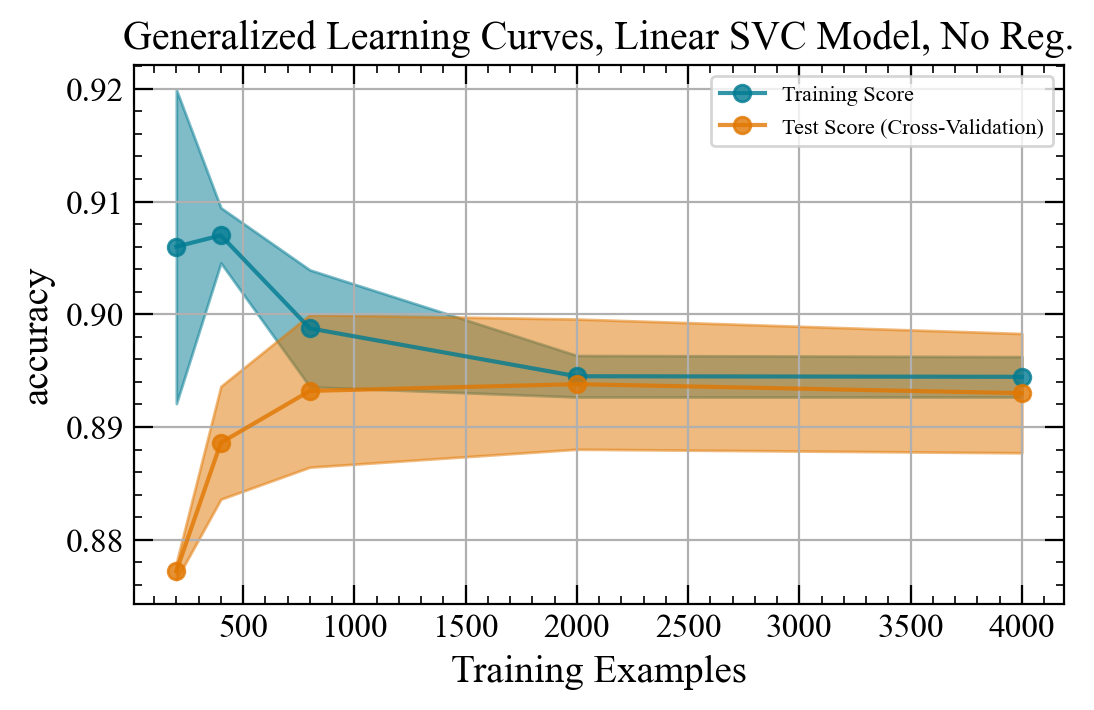

In [25]:
"""
This is a marked improvement over the dummy classifier. The comparison between the train and test scores
additionally gives us information about the problem we have, but this can be formally understood by 
examinging the learning curves.
"""


plot_learning_curve(piped_model, 'Generalized Learning Curves, Linear SVC Model, No Reg.',
                   features_lim, target, train_sizes=np.array([0.05, 0.1, 0.2, 0.5, 1.0]),
                   cv=StratifiedKFold(n_splits=5, shuffle=True))

# Diagnosis

We can tell a few things from the learning curve for this particular algorithm, using this particular feature set:


$\bullet$ adding more data would not help (the curve flattens)

$\bullet$ our model does not suffer from high variance (no difference between train/test scores)

$\bullet$ The likely culprit is then bias. We should aim to make our model more complex

Here, we take a look at increasing complexity by attempting hyperparameter optimization

## Hyperparameter Optimization

The idea here is that there is *some* array of parameter values that will give, on average, the best performance for our algortithm. This is the ordinary optimization problem, but where the parameters are all correlated, so we need to vary them all at the same time.

Notice that this introduces a computational problem when the number of parameters becomes large (the curse of dimensionality). This demands that one take care to think about the problem *before* hyperparameter optimization.

### Grid Search

A common approach is to create a grid of possible parameter combinations, train a model in a cross-validation framework, and then select the combination that yields the best test results.

For our support vector machines we can use the polynomial/Gaussian kernel and co-vary parameters $[d, \gamma, C]$. From a practical perspective, we can easily do this with the $\texttt{GridSearchCV}$ utility from $\texttt{sklearn.model_selection}$, which runs the grid search within the cross-validation framework.

The main task, then is to determine which parameter values to use. There are no hard-and-fast rules, but the guidelines are as follows:

$\bullet$ Start with wide coverage, then refine spacing of the grid

$\bullet$ If best parameters are at the edge of the grid, expand the exploration range

$\bullet$ If grid is too large, try using a random search instead ($\texttt{RandomSearchCV}$)

$\bullet$ Maybe use MCMC or other parameter search techniques, though excessive finetuning of parameters usually results in high variance, so coarse-grained searchs are, in most cases, just fine.


In [26]:
"""
Define a pipeline to make sure data are scaled before optimization
"""

piped_model = make_pipeline(StandardScaler(), SVC()) #use general SVC so kernel can be varied

piped_model.get_params() #shows params for both scaler and classifier

{'memory': None,
 'steps': [('standardscaler', StandardScaler()), ('svc', SVC())],
 'verbose': False,
 'standardscaler': StandardScaler(),
 'svc': SVC(),
 'standardscaler__copy': True,
 'standardscaler__with_mean': True,
 'standardscaler__with_std': True,
 'svc__C': 1.0,
 'svc__break_ties': False,
 'svc__cache_size': 200,
 'svc__class_weight': None,
 'svc__coef0': 0.0,
 'svc__decision_function_shape': 'ovr',
 'svc__degree': 3,
 'svc__gamma': 'scale',
 'svc__kernel': 'rbf',
 'svc__max_iter': -1,
 'svc__probability': False,
 'svc__random_state': None,
 'svc__shrinking': True,
 'svc__tol': 0.001,
 'svc__verbose': False}

In [32]:
parameters = {'svc__kernel' : ['poly', 'rbf'], 'svc__gamma':[0.00001,'scale', 0.01, 0.1],
              'svc__C':[0.1, 1.0, 10.0, 100.0, 1000], 'svc__degree':[2,4,8]}

# Explore
model = GridSearchCV(piped_model, parameters, cv=StratifiedKFold(n_splits=5, shuffle=True),
                    verbose=2, n_jobs=4, return_train_score=True)

model.fit(features_lim, target)

print('Best params, best score:', "{:.4f}".format(model.best_score_), \
      model.best_params_)

Fitting 5 folds for each of 120 candidates, totalling 600 fits
Best params, best score: 0.8982 {'svc__C': 10.0, 'svc__degree': 2, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}


In [33]:
scores_lim = pd.DataFrame(model.cv_results_)
scores_lim.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_svc__C', 'param_svc__degree', 'param_svc__gamma',
       'param_svc__kernel', 'params', 'split0_test_score', 'split1_test_score',
       'split2_test_score', 'split3_test_score', 'split4_test_score',
       'mean_test_score', 'std_test_score', 'rank_test_score',
       'split0_train_score', 'split1_train_score', 'split2_train_score',
       'split3_train_score', 'split4_train_score', 'mean_train_score',
       'std_train_score'],
      dtype='object')

In [35]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_colwidth', 100)

scores_lim[['params','mean_test_score','std_test_score','mean_train_score', \
            'mean_fit_time']].sort_values(by = 'mean_test_score', ascending = False)

,params,mean_test_score,std_test_score,mean_train_score,mean_fit_time
69,"{'svc__C': 10.0, 'svc__degree': 8, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}",0.8982,0.009282,0.91225,0.443824
61,"{'svc__C': 10.0, 'svc__degree': 4, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}",0.8982,0.009282,0.91225,0.449663
53,"{'svc__C': 10.0, 'svc__degree': 2, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}",0.8982,0.009282,0.91225,0.631359
27,"{'svc__C': 1.0, 'svc__degree': 2, 'svc__gamma': 'scale', 'svc__kernel': 'rbf'}",0.8962,0.009745,0.92110,0.534092
43,"{'svc__C': 1.0, 'svc__degree': 8, 'svc__gamma': 'scale', 'svc__kernel': 'rbf'}",0.8962,0.009745,0.92110,0.470483
35,"{'svc__C': 1.0, 'svc__degree': 4, 'svc__gamma': 'scale', 'svc__kernel': 'rbf'}",0.8962,0.009745,0.92110,0.615991
29,"{'svc__C': 1.0, 'svc__degree': 2, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}",0.8940,0.009654,0.90050,0.359705
37,"{'svc__C': 1.0, 'svc__degree': 4, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}",0.8940,0.009654,0.90050,0.433668
45,"{'svc__C': 1.0, 'svc__degree': 8, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}",0.8940,0.009654,0.90050,0.371730
47,"{'svc__C': 1.0, 'svc__degree': 8, 'svc__gamma': 0.1, 'svc__kernel': 'rbf'}",0.8926,0.007172,0.94000,0.652563


In [36]:
scores_lim[scores_lim['param_svc__kernel'] == 'poly'][['params','mean_test_score','std_test_score',\
                        'mean_train_score','mean_fit_time']].sort_values(by = 'mean_test_score', ascending = False)

,params,mean_test_score,std_test_score,mean_train_score,mean_fit_time
98,"{'svc__C': 1000, 'svc__degree': 2, 'svc__gamma': 'scale', 'svc__kernel': 'poly'}",0.8774,0.006053,0.88740,108.259525
100,"{'svc__C': 1000, 'svc__degree': 2, 'svc__gamma': 0.01, 'svc__kernel': 'poly'}",0.8772,0.004707,0.88665,3.437656
54,"{'svc__C': 10.0, 'svc__degree': 2, 'svc__gamma': 0.1, 'svc__kernel': 'poly'}",0.8770,0.004604,0.88675,3.674066
102,"{'svc__C': 1000, 'svc__degree': 2, 'svc__gamma': 0.1, 'svc__kernel': 'poly'}",0.8770,0.006164,0.88730,323.212741
78,"{'svc__C': 100.0, 'svc__degree': 2, 'svc__gamma': 0.1, 'svc__kernel': 'poly'}",0.8770,0.005727,0.88710,32.075606
74,"{'svc__C': 100.0, 'svc__degree': 2, 'svc__gamma': 'scale', 'svc__kernel': 'poly'}",0.8768,0.004534,0.88695,10.940232
26,"{'svc__C': 1.0, 'svc__degree': 2, 'svc__gamma': 'scale', 'svc__kernel': 'poly'}",0.8764,0.008570,0.88255,0.474851
38,"{'svc__C': 1.0, 'svc__degree': 4, 'svc__gamma': 0.1, 'svc__kernel': 'poly'}",0.8756,0.006711,0.96150,1.182750
50,"{'svc__C': 10.0, 'svc__degree': 2, 'svc__gamma': 'scale', 'svc__kernel': 'poly'}",0.8752,0.006969,0.88620,1.284271
58,"{'svc__C': 10.0, 'svc__degree': 4, 'svc__gamma': 'scale', 'svc__kernel': 'poly'}",0.8750,0.006986,0.96075,1.023396


# Analysis of Results

$\bullet$ Top 10 models are all Gaussian kernel and have similar test scores

$\bullet$ Winning model scores show only slight improvement over our earlier linear model

$\bullet$ Winning models suffer from high variance (test/train scores suffer $\sim 3\sigma$ difference)

Adding complexity to our model by using poly/Gaussian kernels has increased the variance, and Ockham's Razor compels us to select the simpler, linear model which is just as effective.

So we turn to the linear model's problem with high bias. We can try two things: (1) make up new features (feature engineering) or (2) impute values for missing features.

# A Note on Nested Cross-Validation

The way I am doing things now is fine for the exercise, but there is a conceptual concern here. When using the test scores as a metric for determining the best parameters, we are in a sense letting the optimization be influenced by the test set. A solution to this problem is to nest the cross-validation technique. One creates $k$ splits of the learning set and in each of the $k-1$ partitions we repeat an $n$-fold CV scheme, splitting the partition into inner train/test sets $n$ times.

Unfortunately, even for just this example, nested CV can be very expensive. For our 120 testing models here we would have to train the system 1,200 times for the minimum 5 outer folds and 4 inner folds. Yikes.

# Feature Engineering

The first step in this process to develop features that "make sense." This can come from physical intuition about the situation at hand. For the case of particle physics, and the features at hand, we might think that features related to the product particles might be useful. Here we will try

1. Total number of particles produced

2. The total number of b jets

3. The total number of jets

4. The total number of leptons (electrons, positrons, muons)

In [37]:
features = features.fillna(0) # remove NaNs
features = features.replace('', 0) # remove empty strings
features.head()

,MET,METphi,Type_1,P1,P2,P3,P4,Type_2,P5,P6,P7,P8,Type_3,P9,P10,P11,P12,Type_4,P13,P14,P15,P16,Type_5,P17,P18,P19,P20,Type_6,P21,P22,P23,P24,Type_7,P25,P26,P27,P28,Type_8,P29,P30,P31,P32,Type_9,P33,P34,P35,P36,Type_10,P37,P38,P39,P40,Type_11,P41,P42,P43,P44,Type_12,P45,P46,P47,P48,Type_13,P49,P50,P51,P52
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,62803.5,-1.810010,j,137571.0,128444.0,-0.345744,-0.307112,j,174209.0,127932.0,0.826569,2.332000,b,86788.9,84554.9,-0.180795,2.187970,j,140289.0,76955.8,-1.19933,-1.302800,m+,85230.6,70102.4,-0.645689,-1.659540,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0
1,57594.2,-0.509253,j,161529.0,80458.3,-1.318010,1.402050,j,291490.0,68462.9,-2.126740,-2.582310,e-,44270.1,35139.6,-0.706120,-0.371392,e+,72883.9,26902.2,-1.65386,-3.129630,0,0.0,0.0,0.000000,0.000000,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0
2,82313.3,1.686840,b,167130.0,113078.0,0.937258,-2.068680,j,102423.0,54922.3,1.226850,0.646589,j,60768.9,36244.3,1.102890,-1.434480,j,77714.0,27801.5,1.68461,1.389690,j,26840.0,24469.3,-0.388937,-1.647260,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0
3,30610.8,2.617120,j,112267.0,61383.9,-1.211050,-1.457800,b,40647.8,39472.0,-0.024646,-2.222800,j,201589.0,32978.6,-2.496040,1.137810,j,90096.7,26964.5,1.87132,0.817631,j,28235.4,25887.9,-0.411528,2.024290,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0
4,45153.1,-2.241350,j,178174.0,100164.0,1.166880,-0.018721,j,92351.3,69762.1,0.774114,2.568740,j,61625.2,50086.7,0.652572,-3.012800,j,104193.0,31151.0,1.87641,0.865381,j,746585.0,26219.3,4.041820,-0.874169,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0


In [38]:
"View the kinds of particles we have as a result of the collision"

np.unique(np.array([features['Type_'+str(i)].values for i in range(1,14)]).astype('str'))

array(['0', 'b', 'e+', 'e-', 'g', 'j', 'm+', 'm-'], dtype='<U2')

In [43]:
"""Define new features and add to dataframe"""

ntot = np.array([-(np.sum(np.array([features['Type_'+str(i)].values[j] == 0 for i in range(1,14)])) - 13) for j in range(features.shape[0])])
nbtot = np.array([np.sum(np.array([features['Type_'+str(i)].values[j] == 'b' for i in range(1,14)])) for j in range(features.shape[0])])
njtot = np.array([np.sum(np.array([features['Type_'+str(i)].values[j] == 'j' for i in range(1,14)])) for j in range(features.shape[0])])
ngtot = np.array([np.sum(np.array([features['Type_'+str(i)].values[j] == 'g' for i in range(1,14)])) for j in range(features.shape[0])])
n_el_tot = np.array([np.sum(np.array([features['Type_'+str(i)].values[j] == 'e-' for i in range(1,14)])) for j in range(features.shape[0])])
n_pos_tot = np.array([np.sum(np.array([features['Type_'+str(i)].values[j] == 'e+' for i in range(1,14)])) for j in range(features.shape[0])])
n_muneg_tot = np.array([np.sum(np.array([features['Type_'+str(i)].values[j] == 'm-' for i in range(1,14)])) for j in range(features.shape[0])])
n_mupos_tot = np.array([np.sum(np.array([features['Type_'+str(i)].values[j] == 'm+' for i in range(1,14)])) for j in range(features.shape[0])])
n_lepton_tot = n_el_tot + n_pos_tot + n_muneg_tot + n_mupos_tot

features['Total_products'] = ntot
features['Total_b'] = nbtot
features['Total_j'] = njtot
features['Total_g'] = ngtot
features['Total_leptons'] = n_lepton_tot

In [44]:
"""Define new, limited set of features for exercise"""

features_lim_2 = features[['MET', 'METphi', 'P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'P10', 'P11',
       'P12',  'P13', 'P14', 'P15', 'P16','Total_products', 'Total_b' ,'Total_j','Total_g', 
              'Total_leptons']]

In [48]:
piped_model = make_pipeline(StandardScaler(), LinearSVC(dual=False))
benchmark_lim2_piped = cross_validate(piped_model, features_lim_2, target, cv=cv, scoring='accuracy',
                                     return_train_score=True)
benchmark_lim2_piped

{'fit_time': array([0.04159617, 0.01201034, 0.00901437, 0.00799942, 0.01023817]),
 'score_time': array([0.01404548, 0.00207138, 0.00199485, 0.00099826, 0.00199652]),
 'test_score': array([0.952, 0.939, 0.961, 0.948, 0.94 ]),
 'train_score': array([0.95   , 0.9555 , 0.94825, 0.95   , 0.95   ])}

In [49]:
benchmark_lim2_piped['test_score'].mean().round(3), benchmark_lim2_piped['test_score'].std().round(3)

(0.948, 0.008)

In [50]:
import time

In [53]:
%%time
"""
This is a significant improvement over our random classifier and negative guesser
Compare 95% to 83% to 74%

We can also try optimizing, though we should guess that in this case we will end up with
higher variance for little to no improvement.
"""

piped_model = make_pipeline(StandardScaler(), SVC())

parameters = {'svc__kernel':['poly', 'rbf'],
             'svc__gamma':[0.0001, 'scale', 0.01, 0.1],
             'svc__C':[0.1, 1.0, 10.0, 100.0],
             'svc__degree':[2, 4, 8]}

model = GridSearchCV(piped_model, parameters, cv=StratifiedKFold(n_splits=5, shuffle=True),
                    verbose=2, n_jobs=4, return_train_score=True)

model.fit(features_lim_2, target)

print('Best params, best score:', "{:.4f}".format(model.best_score_), model.best_params_)

Fitting 5 folds for each of 96 candidates, totalling 480 fits
Best params, best score: 0.9466 {'svc__C': 100.0, 'svc__degree': 2, 'svc__gamma': 0.0001, 'svc__kernel': 'rbf'}
Wall time: 3min 12s


In [54]:
scores_lim_2 = pd.DataFrame(model.cv_results_)
scores_lim_2[['params','mean_test_score','mean_train_score','mean_fit_time']].sort_values(by = 'mean_test_score', \
                                                    ascending = False)

,params,mean_test_score,mean_train_score,mean_fit_time
73,"{'svc__C': 100.0, 'svc__degree': 2, 'svc__gamma': 0.0001, 'svc__kernel': 'rbf'}",0.9466,0.95090,0.196809
81,"{'svc__C': 100.0, 'svc__degree': 4, 'svc__gamma': 0.0001, 'svc__kernel': 'rbf'}",0.9466,0.95090,0.202314
89,"{'svc__C': 100.0, 'svc__degree': 8, 'svc__gamma': 0.0001, 'svc__kernel': 'rbf'}",0.9466,0.95090,0.192638
45,"{'svc__C': 1.0, 'svc__degree': 8, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}",0.9446,0.95375,0.210384
29,"{'svc__C': 1.0, 'svc__degree': 2, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}",0.9446,0.95375,0.204855
37,"{'svc__C': 1.0, 'svc__degree': 4, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}",0.9446,0.95375,0.240998
49,"{'svc__C': 10.0, 'svc__degree': 2, 'svc__gamma': 0.0001, 'svc__kernel': 'rbf'}",0.9442,0.94475,0.254509
65,"{'svc__C': 10.0, 'svc__degree': 8, 'svc__gamma': 0.0001, 'svc__kernel': 'rbf'}",0.9442,0.94475,0.361735
57,"{'svc__C': 10.0, 'svc__degree': 4, 'svc__gamma': 0.0001, 'svc__kernel': 'rbf'}",0.9442,0.94475,0.253973
53,"{'svc__C': 10.0, 'svc__degree': 2, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}",0.9432,0.96245,0.270390


In [55]:
"""
These are good, but not any better than the simpler linear SVC

One can always poke around with more features. The ones we tried above worked out well, after all.
We might expect adding more features will improve our model even more, but only if they are informed.
Adding arbitary features will just lead to more variance, since we are making our model more complicated
than it needs to be to explain the data.

Example: Using the product particle in the i-th location as a feature
If particle j is in position i, then the feature is 1, else it is 0.
"""

# create new features for each particle type
features_add = pd.get_dummies(data=features, columns=['Type_'+str(i) for i in range(1,14)])
features_add.columns[58:] #view all new features

Index(['Total_leptons', 'Type_1_b', 'Type_1_j', 'Type_2_0', 'Type_2_b',
       'Type_2_e+', 'Type_2_e-', 'Type_2_g', 'Type_2_j', 'Type_2_m+',
       'Type_2_m-', 'Type_3_0', 'Type_3_b', 'Type_3_e+', 'Type_3_e-',
       'Type_3_g', 'Type_3_j', 'Type_3_m+', 'Type_3_m-', 'Type_4_0',
       'Type_4_b', 'Type_4_e+', 'Type_4_e-', 'Type_4_g', 'Type_4_j',
       'Type_4_m+', 'Type_4_m-', 'Type_5_0', 'Type_5_b', 'Type_5_e+',
       'Type_5_e-', 'Type_5_g', 'Type_5_j', 'Type_5_m+', 'Type_5_m-',
       'Type_6_0', 'Type_6_b', 'Type_6_e+', 'Type_6_e-', 'Type_6_g',
       'Type_6_j', 'Type_6_m+', 'Type_6_m-', 'Type_7_0', 'Type_7_b',
       'Type_7_e+', 'Type_7_e-', 'Type_7_g', 'Type_7_j', 'Type_7_m+',
       'Type_7_m-', 'Type_8_0', 'Type_8_b', 'Type_8_e+', 'Type_8_e-',
       'Type_8_g', 'Type_8_j', 'Type_8_m+', 'Type_8_m-', 'Type_9_0',
       'Type_9_b', 'Type_9_e+', 'Type_9_e-', 'Type_9_g', 'Type_9_j',
       'Type_9_m+', 'Type_9_m-', 'Type_10_0', 'Type_10_b', 'Type_10_e+',
       'Type_10_e-', 

In [57]:
features_lim_3 = features_add[['MET', 'METphi', 'P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'P10', 'P11',
       'P12',  'P13', 'P14', 'P15', 'P16','Total_products', 'Total_b' ,'Total_j','Total_g', 
              'Total_leptons','Type_1_b',
       'Type_1_j', 'Type_2_0', 'Type_2_b', 'Type_2_e+', 'Type_2_e-',
       'Type_2_g', 'Type_2_j', 'Type_2_m+', 'Type_2_m-', 'Type_3_0',
       'Type_3_b', 'Type_3_e+', 'Type_3_e-', 'Type_3_g', 'Type_3_j',
       'Type_3_m+', 'Type_3_m-', 'Type_4_0', 'Type_4_b', 'Type_4_e+',
       'Type_4_e-', 'Type_4_g', 'Type_4_j', 'Type_4_m+', 'Type_4_m-']]

features_lim_3.head()

,MET,METphi,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,P11,P12,P13,P14,P15,P16,Total_products,Total_b,Total_j,Total_g,Total_leptons,Type_1_b,Type_1_j,Type_2_0,Type_2_b,Type_2_e+,Type_2_e-,Type_2_g,Type_2_j,Type_2_m+,Type_2_m-,Type_3_0,Type_3_b,Type_3_e+,Type_3_e-,Type_3_g,Type_3_j,Type_3_m+,Type_3_m-,Type_4_0,Type_4_b,Type_4_e+,Type_4_e-,Type_4_g,Type_4_j,Type_4_m+,Type_4_m-
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,62803.5,-1.810010,137571.0,128444.0,-0.345744,-0.307112,174209.0,127932.0,0.826569,2.332000,86788.9,84554.9,-0.180795,2.187970,140289.0,76955.8,-1.19933,-1.302800,5,1,3,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,57594.2,-0.509253,161529.0,80458.3,-1.318010,1.402050,291490.0,68462.9,-2.126740,-2.582310,44270.1,35139.6,-0.706120,-0.371392,72883.9,26902.2,-1.65386,-3.129630,4,0,2,0,2,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0
2,82313.3,1.686840,167130.0,113078.0,0.937258,-2.068680,102423.0,54922.3,1.226850,0.646589,60768.9,36244.3,1.102890,-1.434480,77714.0,27801.5,1.68461,1.389690,5,1,4,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
3,30610.8,2.617120,112267.0,61383.9,-1.211050,-1.457800,40647.8,39472.0,-0.024646,-2.222800,201589.0,32978.6,-2.496040,1.137810,90096.7,26964.5,1.87132,0.817631,5,1,4,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
4,45153.1,-2.241350,178174.0,100164.0,1.166880,-0.018721,92351.3,69762.1,0.774114,2.568740,61625.2,50086.7,0.652572,-3.012800,104193.0,31151.0,1.87641,0.865381,5,0,5,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0


In [59]:
piped_model = make_pipeline(StandardScaler(), LinearSVC(dual = False))
benchmark = cross_validate(piped_model, features_lim_3, target, cv = cv, scoring = 'accuracy', return_train_score=True)
benchmark['test_score'].mean().round(3), benchmark['test_score'].std().round(3)

(0.948, 0.008)

In [60]:
benchmark['train_score'].mean().round(3), benchmark['train_score'].std().round(3)

(0.951, 0.003)

# Summary

$\bullet$ Applied full problem-solving pipeline, from data exploration to preprocessing to optimization

$\bullet$ Used content-based feature engineering to alleviate high-bias in a model

$\bullet$ Imputed values for missing feature examples